In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from scipy.spatial.distance import cdist
import datetime
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [145]:
customers = pd.read_csv("/content/drive/MyDrive/Customers.csv")
transactions = pd.read_csv("/content/drive/MyDrive/Transactions.csv")
df = pd.merge(customers, transactions, on="CustomerID", how="inner")

In [146]:
df.head(10)

,CustomerID,CustomerName,Region,SignupDate,TransactionID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,C0001,Lawrence Carroll,South America,2022-07-10,T00015,P054,2024-01-19 3:12:55,2,114.60,57.30
1,C0001,Lawrence Carroll,South America,2022-07-10,T00932,P022,2024-09-17 9:01:18,3,412.62,137.54
2,C0001,Lawrence Carroll,South America,2022-07-10,T00085,P096,2024-04-08 0:01:00,2,614.94,307.47
3,C0001,Lawrence Carroll,South America,2022-07-10,T00445,P083,2024-05-07 3:11:44,2,911.44,455.72
4,C0001,Lawrence Carroll,South America,2022-07-10,T00436,P029,2024-11-02 17:04:16,3,1300.92,433.64
5,C0002,Elizabeth Lutz,Asia,2022-02-13,T00155,P095,2024-07-12 10:18:13,2,454.52,227.26
6,C0002,Elizabeth Lutz,Asia,2022-02-13,T00129,P004,2024-06-11 23:59:08,4,382.76,95.69
7,C0002,Elizabeth Lutz,Asia,2022-02-13,T00148,P019,2024-02-28 7:44:21,2,770.74,385.37
8,C0002,Elizabeth Lutz,Asia,2022-02-13,T00675,P071,2024-12-03 1:41:41,2,254.72,127.36
9,C0003,Michael Rivera,South America,2024-03-07,T00462,P025,2024-06-03 19:17:36,3,853.86,284.62


In [147]:
customer_data

,CustomerID,SignupDate,Region
0,C0001,2022-07-10,South America
5,C0002,2022-02-13,Asia
9,C0003,2024-03-07,South America
13,C0004,2022-10-09,South America
21,C0005,2022-08-15,Asia
...,...,...,...
982,C0196,2022-06-07,Europe
986,C0197,2023-03-21,Europe
989,C0198,2022-02-27,Europe
991,C0199,2022-12-03,Europe


In [148]:
# Convert dates to datetime
df["SignupDate"] = pd.to_datetime(df["SignupDate"])
df["TransactionDate"] = pd.to_datetime(df["TransactionDate"])

# Calculate first transaction date per customer
first_transaction = df.groupby("CustomerID")["TransactionDate"].min().reset_index()

customer_data = df[["CustomerID", "SignupDate", "Region"]].drop_duplicates()
merged = pd.merge(customer_data, first_transaction, on="CustomerID")
merged

,CustomerID,SignupDate,Region,TransactionDate
0,C0001,2022-07-10,South America,2024-01-19 03:12:55
1,C0002,2022-02-13,Asia,2024-02-28 07:44:21
2,C0003,2024-03-07,South America,2024-02-18 02:50:37
3,C0004,2022-10-09,South America,2024-02-28 10:16:35
4,C0005,2022-08-15,Asia,2024-03-15 04:08:59
...,...,...,...,...
194,C0196,2022-06-07,Europe,2024-08-06 14:37:15
195,C0197,2023-03-21,Europe,2024-01-13 04:52:09
196,C0198,2022-02-27,Europe,2024-09-29 16:14:59
197,C0199,2022-12-03,Europe,2024-08-17 12:06:08


In [149]:
merged["DaysToFirstPurchase"] = (merged["TransactionDate"] - merged["SignupDate"]).dt.days
merged

,CustomerID,SignupDate,Region,TransactionDate,DaysToFirstPurchase
0,C0001,2022-07-10,South America,2024-01-19 03:12:55,558
1,C0002,2022-02-13,Asia,2024-02-28 07:44:21,745
2,C0003,2024-03-07,South America,2024-02-18 02:50:37,-18
3,C0004,2022-10-09,South America,2024-02-28 10:16:35,507
4,C0005,2022-08-15,Asia,2024-03-15 04:08:59,578
...,...,...,...,...,...
194,C0196,2022-06-07,Europe,2024-08-06 14:37:15,791
195,C0197,2023-03-21,Europe,2024-01-13 04:52:09,298
196,C0198,2022-02-27,Europe,2024-09-29 16:14:59,945
197,C0199,2022-12-03,Europe,2024-08-17 12:06:08,623


In [150]:
customer_spending = df.groupby("CustomerID").agg({
    "TransactionID": "count",
    "TotalValue": ["sum", "mean"]
}).reset_index()

customer_spending.columns = ['CustomerID', 'NumTransactions', 'TotalSpending', 'AvgSpending']

customer_spending

,CustomerID,NumTransactions,TotalSpending,AvgSpending
0,C0001,5,3354.52,670.904000
1,C0002,4,1862.74,465.685000
2,C0003,4,2725.38,681.345000
3,C0004,8,5354.88,669.360000
4,C0005,3,2034.24,678.080000
...,...,...,...,...
194,C0196,4,4982.88,1245.720000
195,C0197,3,1928.65,642.883333
196,C0198,2,931.83,465.915000
197,C0199,4,1979.28,494.820000


In [151]:
final_df = pd.merge(merged, customer_spending, on="CustomerID")
final_df

,CustomerID,SignupDate,Region,TransactionDate,DaysToFirstPurchase,NumTransactions,TotalSpending,AvgSpending
0,C0001,2022-07-10,South America,2024-01-19 03:12:55,558,5,3354.52,670.904000
1,C0002,2022-02-13,Asia,2024-02-28 07:44:21,745,4,1862.74,465.685000
2,C0003,2024-03-07,South America,2024-02-18 02:50:37,-18,4,2725.38,681.345000
3,C0004,2022-10-09,South America,2024-02-28 10:16:35,507,8,5354.88,669.360000
4,C0005,2022-08-15,Asia,2024-03-15 04:08:59,578,3,2034.24,678.080000
...,...,...,...,...,...,...,...,...
194,C0196,2022-06-07,Europe,2024-08-06 14:37:15,791,4,4982.88,1245.720000
195,C0197,2023-03-21,Europe,2024-01-13 04:52:09,298,3,1928.65,642.883333
196,C0198,2022-02-27,Europe,2024-09-29 16:14:59,945,2,931.83,465.915000
197,C0199,2022-12-03,Europe,2024-08-17 12:06:08,623,4,1979.28,494.820000


In [152]:
final_df = final_df.drop(columns=["SignupDate", "TransactionDate"])
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           199 non-null    object 
 1   Region               199 non-null    object 
 2   DaysToFirstPurchase  199 non-null    int64  
 3   NumTransactions      199 non-null    int64  
 4   TotalSpending        199 non-null    float64
 5   AvgSpending          199 non-null    float64
dtypes: float64(2), int64(2), object(2)
memory usage: 9.5+ KB


In [153]:
ids=final_df["CustomerID"]
final_df=final_df.drop(columns=["CustomerID"])

In [154]:
encoder = LabelEncoder()
final_df["Region"] = encoder.fit_transform(final_df["Region"])

In [155]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(final_df)

# Determine optimal number of clusters using Elbow Method
inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

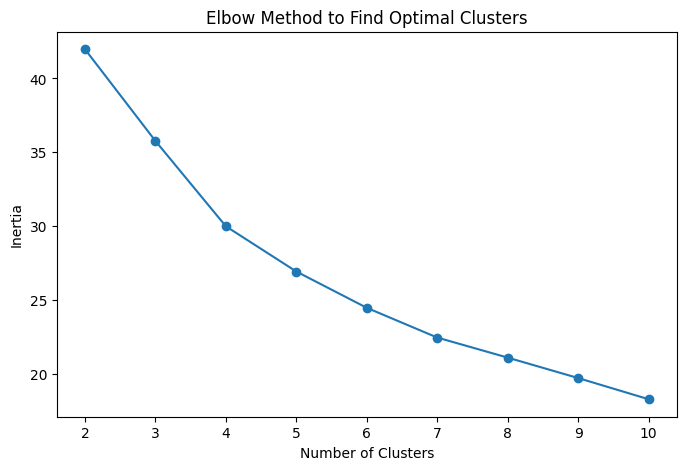

In [156]:
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method to Find Optimal Clusters")
plt.show()

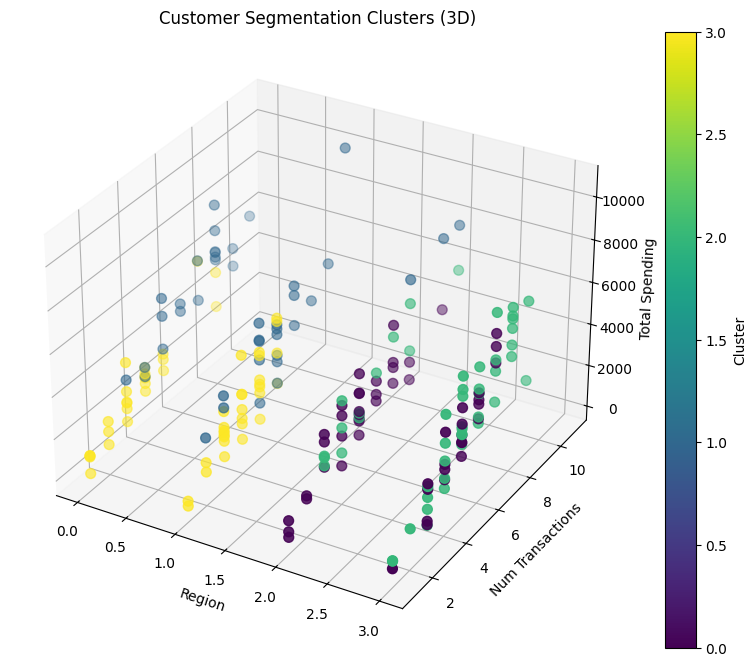

In [157]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
final_df["Cluster"] = kmeans.fit_predict(scaled_data)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(final_df["Region"], final_df["NumTransactions"], final_df["TotalSpending"],
                c=final_df["Cluster"], cmap="viridis", s=50)

ax.set_xlabel("Region")
ax.set_ylabel("Num Transactions")
ax.set_zlabel("Total Spending")
ax.set_title("Customer Segmentation Clusters (3D)")

plt.colorbar(sc, label="Cluster")
plt.show()


###k=4 didnt show good results so we will try with k=5.

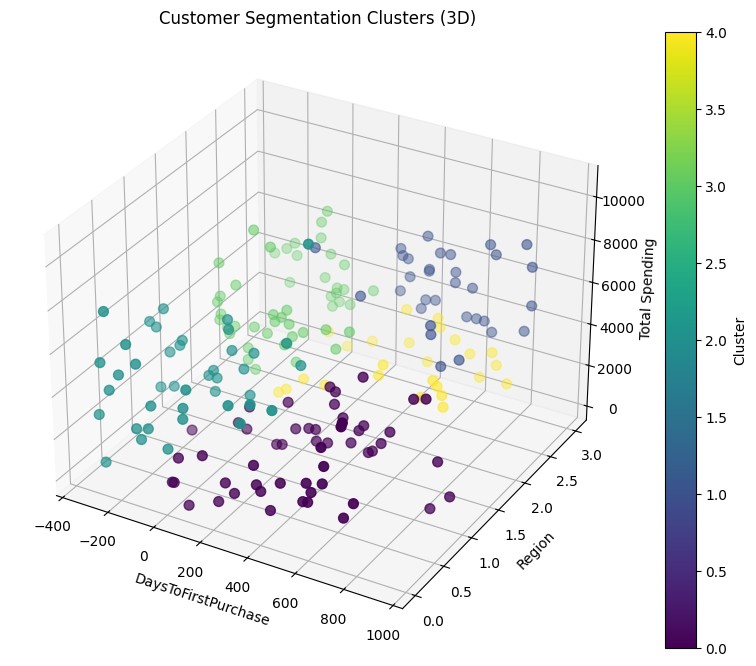

In [165]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
final_df["Cluster"] = kmeans.fit_predict(scaled_data)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(final_df["DaysToFirstPurchase"], final_df["Region"], final_df["TotalSpending"],
                c=final_df["Cluster"], cmap="viridis", s=50)

ax.set_xlabel("DaysToFirstPurchase")
ax.set_ylabel("Region")
ax.set_zlabel("Total Spending")
ax.set_title("Customer Segmentation Clusters (3D)")

plt.colorbar(sc, label="Cluster")
plt.show()

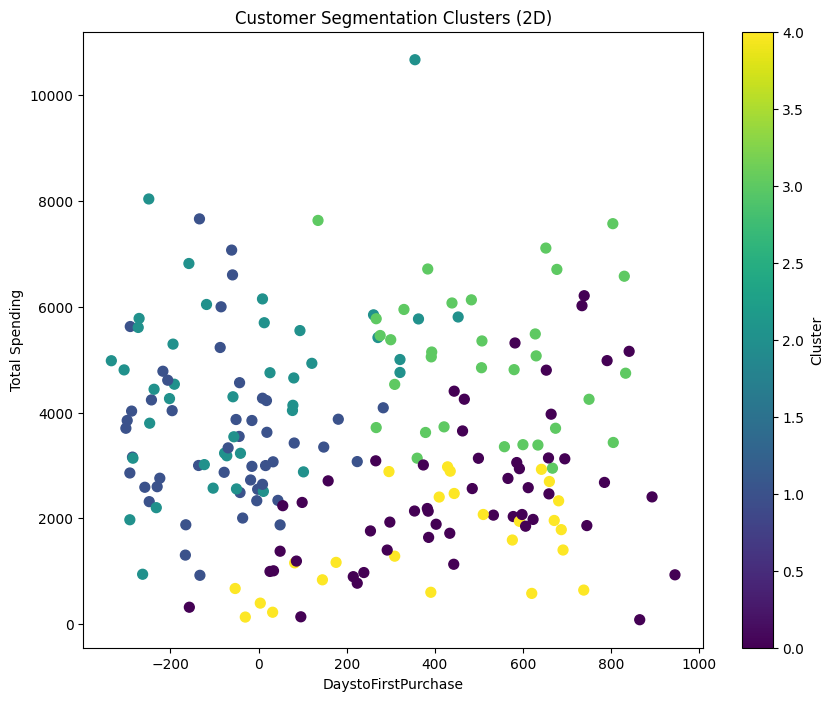

In [159]:
plt.figure(figsize=(10, 8))
sc = plt.scatter(final_df["DaysToFirstPurchase"], final_df["TotalSpending"], c=final_df["Cluster"], cmap="viridis", s=50)

plt.xlabel("DaystoFirstPurchase")
plt.ylabel("Total Spending")
plt.title("Customer Segmentation Clusters (2D)")

plt.colorbar(sc, label="Cluster")
plt.show()


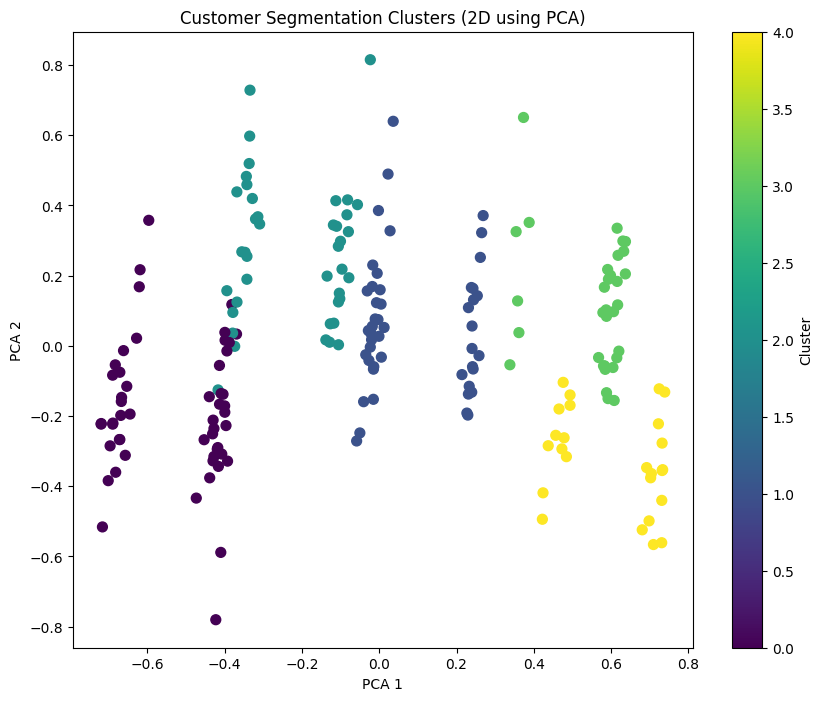

In [160]:
scaled_data=scaler.fit_transform(final_df)

pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

final_df["PCA1"] = pca_components[:, 0]
final_df["PCA2"] = pca_components[:, 1]

plt.figure(figsize=(10, 8))
sc = plt.scatter(final_df["PCA1"], final_df["PCA2"], c=final_df["Cluster"], cmap="viridis", s=50)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Customer Segmentation Clusters (2D using PCA)")

plt.colorbar(sc, label="Cluster")
plt.show()

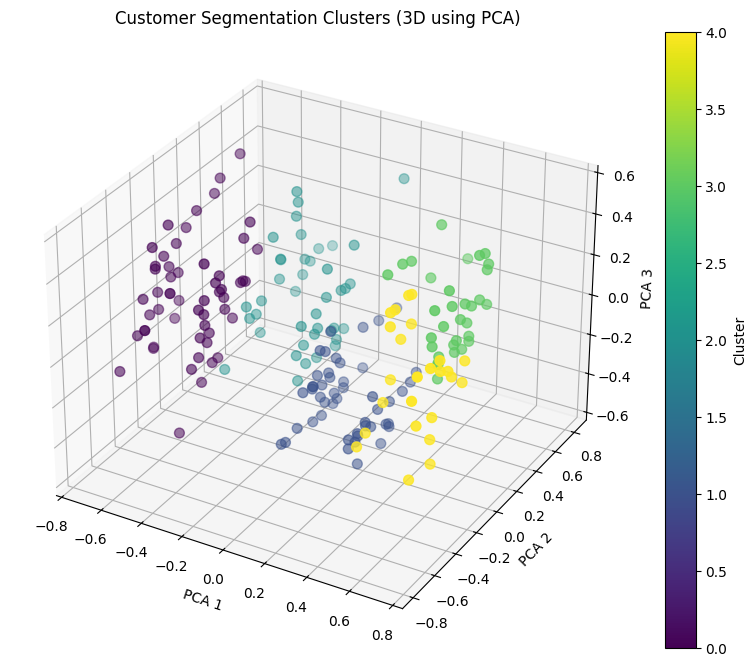

In [161]:
pca = PCA(n_components=3)
pca_components = pca.fit_transform(scaled_data)

final_df["PCA1"] = pca_components[:, 0]
final_df["PCA2"] = pca_components[:, 1]
final_df["PCA3"] = pca_components[:, 2]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(final_df["PCA1"], final_df["PCA2"], final_df["PCA3"],
                c=final_df["Cluster"], cmap="viridis", s=50)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_title("Customer Segmentation Clusters (3D using PCA)")

plt.colorbar(sc, label="Cluster")
plt.show()

In [162]:
db_index = davies_bouldin_score(scaled_data, final_df["Cluster"])
print(f"Davies-Bouldin Index: {db_index:.3f}")


Davies-Bouldin Index: 1.051


In [163]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(scaled_data, final_df["Cluster"])
print(f"Silhouette Score: {silhouette_avg:.3f}")


Silhouette Score: 0.372


In [164]:
inertia = kmeans.inertia_
print(f"Inertia (Within-Cluster Sum of Squares): {inertia}")


Inertia (Within-Cluster Sum of Squares): 26.915887673667683
